In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2025-06-18 16:55:17.179003: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 16:55:17.431009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750265717.537187    2067 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750265717.565035    2067 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750265717.774989    2067 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# Path to your single dataset folder (should have subfolders for each class)
data_dir = '/teamspace/studios/this_studio/new_papaya_Anis/new_papaya'  # e.g., 'vegetable_dataset/'

# Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # DenseNet121 default input size
NUM_CLASSES = 6
EPOCHS = 15
VAL_SPLIT = 0.2  # 20% for validation
TEST_SPLIT = 0.1  # 10% for testing

In [4]:
# Step 2: Load and preprocess dataset with progress bar
def load_dataset(data_dir):
    images = []
    labels = []

    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} not found!")
            continue

        print(f"Loading {class_name} images...")
        for img_file in tqdm(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_file)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Ensure RGB format
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.array(img) / 255.0
                    if img_array.shape == (*IMAGE_SIZE, 3):
                        images.append(img_array)
                        labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

In [5]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
import numpy as np
import os

# 🏷️ Get class names
class_names = sorted(os.listdir(data_dir))
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# 🖼️ Load file paths and labels
file_paths = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        file_paths.append(img_path)
        labels.append(class_idx)

file_paths = np.array(file_paths)
labels = np.array(labels)

# 🧼 Load and preprocess images
X_images = []
for img_path in file_paths:
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    X_images.append(img.numpy())

X_images = np.array(X_images)
y = labels

# 🔀 Split data: 15% test first
X_temp, X_test, y_temp, y_test = train_test_split(
    X_images, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

# 🔀 Now split X_temp into 82.35% train and 17.65% val to make them 70% and 15% of original
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.1765,  # 15% of original = 15/85 ≈ 0.1765
    random_state=42, 
    stratify=y_temp
)

print(f"\nOriginal counts: {Counter(y)}")
print(f"Train: {len(X_train)} (before SMOTE), Val: {len(X_val)}, Test: {len(X_test)}")

# 🔁 Apply SMOTE
print("\nApplying SMOTE to training data...")
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42)
X_train_smote_flat, y_train_smote = smote.fit_resample(X_train_flat, y_train)
X_train_smote = X_train_smote_flat.reshape(-1, *X_train.shape[1:])

print(f"Before SMOTE: {X_train.shape[0]} samples")
print(f"After SMOTE: {X_train_smote.shape[0]} samples")
print("Class distribution after SMOTE:", Counter(y_train_smote))

# 📦 Create TF datasets
def create_dataset(X, y):
    return tf.data.Dataset.from_tensor_slices((X, tf.one_hot(y, depth=NUM_CLASSES)))

train_ds = create_dataset(X_train_smote, y_train_smote).shuffle(1000).batch(BATCH_SIZE)
val_ds = create_dataset(X_val, y_val).batch(BATCH_SIZE)
test_ds = create_dataset(X_test, y_test).batch(BATCH_SIZE)

print("\n✅ Dataset sizes:")
print(f"Training samples: {len(X_train_smote)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Classes: ['Bacterial_Blight', 'Carica_Insect_Hole', 'Curled_Yellow_Spot', 'Yellow_Necrotic_Spots_Holes', 'healthy_leaf', 'pathogen_symptoms']


I0000 00:00:1750265743.727859    2067 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9



Original counts: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000})
Train: 4199 (before SMOTE), Val: 901, Test: 900

Applying SMOTE to training data...
Before SMOTE: 4199 samples
After SMOTE: 4200 samples
Class distribution after SMOTE: Counter({2: 700, 0: 700, 1: 700, 3: 700, 5: 700, 4: 700})

✅ Dataset sizes:
Training samples: 4200
Validation samples: 901
Test samples: 900


In [7]:
from tensorflow.keras.applications import DenseNet201  # ✅ Correct import
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# 🧩 Model settings
input_shape = (224, 224, 3)
NUM_CLASSES = 6  # Adjust as per your dataset

# ⚙️ Load DenseNet169 base model with ImageNet weights (excluding top)
base_model = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = True  # Fine-tune whole model

# 🔨 Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# 🧠 Final model
model = Model(inputs=base_model.input, outputs=predictions)

# 🧪 Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# 📋 Model summary
model.summary()


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,308,614 (73.66 MB)

 Trainable params: 19,079,558 (72.78 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [8]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [visualkeras]


In [9]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=800)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ✅ Define model name manually
model_name = "DenseNet201"

# ✅ Callbacks (using correct model name)
checkpoint = ModelCheckpoint(
    f"{model_name}.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-4
)

# ✅ Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/15


I0000 00:00:1750266005.694278    3942 service.cc:152] XLA service 0x765168002660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750266005.694621    3942 service.cc:160]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-06-18 17:00:09.377850: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750266024.793503    3942 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-06-18 17:00:36.777807: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51037_0', 32 bytes spill stores, 32 bytes spill loads

2025-06-18 17:00:36.987819: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51037', 40 bytes

131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6987 - loss: 0.8038 - precision: 0.8212 - recall: 0.5947

2025-06-18 17:07:44.779166: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51037', 12 bytes spill stores, 12 bytes spill loads

2025-06-18 17:07:44.857761: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51037', 8 bytes spill stores, 8 bytes spill loads

2025-06-18 17:07:45.304122: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51037', 264 bytes spill stores, 264 bytes spill loads

2025-06-18 17:07:45.437305: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51037', 44 bytes spill stores, 44 bytes spill loads

2025-06-18 17:07:46.349366: I extern

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6998 - loss: 0.8009 - precision: 0.8219 - recall: 0.5962   

2025-06-18 17:15:31.969233: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5468', 4 bytes spill stores, 4 bytes spill loads

2025-06-18 17:15:32.627736: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5468', 92 bytes spill stores, 92 bytes spill loads

2025-06-18 17:15:32.790067: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5468', 76 bytes spill stores, 76 bytes spill loads

2025-06-18 17:15:54.461701: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5461', 12 bytes spill stores, 12 bytes spill loads

2025-06-18 17:15:55.063548: I external/loc

132/132 ━━━━━━━━━━━━━━━━━━━━ 1062s 4s/step - accuracy: 0.7009 - loss: 0.7981 - precision: 0.8227 - recall: 0.5977 - val_accuracy: 0.9656 - val_loss: 0.1121 - val_precision: 0.9688 - val_recall: 0.9656 - learning_rate: 1.0000e-04
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9866 - loss: 0.0488 - precision: 0.9894 - recall: 0.9848

132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 255ms/step - accuracy: 0.9866 - loss: 0.0488 - precision: 0.9894 - recall: 0.9848 - val_accuracy: 0.9878 - val_loss: 0.0345 - val_precision: 0.9889 - val_recall: 0.9878 - learning_rate: 1.0000e-04
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9967 - loss: 0.0159 - precision: 0.9977 - recall: 0.9962

132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.9967 - loss: 0.0160 - precision: 0.9977 - recall: 0.9962 - val_accuracy: 0.9933 - val_loss: 0.0263 - val_precision: 0.9944 - val_recall: 0.9911 - learning_rate: 1.0000e-04
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9915 - loss: 0.0259 - precision: 0.9923 - recall: 0.9909 - val_accuracy: 0.9623 - val_loss: 0.1471 - val_precision: 0.9644 - val_recall: 0.9612 - learning_rate: 1.0000e-04
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9884 - loss: 0.0390 - precision: 0.9889 - recall: 0.9874 - val_accuracy: 0.9911 - val_loss: 0.0313 - val_precision: 0.9922 - val_recall: 0.9911 - learning_rate: 1.0000e-04
Epoch 6/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9956 - loss: 0.0144 - precision: 0.9968 - recall: 0.9952 - val_accuracy: 0.9911 - val_loss: 0.0280 - val_precision: 0.9933 - val_recall: 0.9911 - learning_rate: 1.0000e-04
Epoch 7/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 238

132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy: 0.9946 - loss: 0.0189 - precision: 0.9956 - recall: 0.9936 - val_accuracy: 0.9945 - val_loss: 0.0162 - val_precision: 0.9945 - val_recall: 0.9945 - learning_rate: 1.0000e-04
Epoch 9/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9964 - loss: 0.0144 - precision: 0.9969 - recall: 0.9953 - val_accuracy: 0.9689 - val_loss: 0.0848 - val_precision: 0.9689 - val_recall: 0.9667 - learning_rate: 1.0000e-04
Epoch 10/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9957 - loss: 0.0173 - precision: 0.9960 - recall: 0.9957 - val_accuracy: 0.9845 - val_loss: 0.0564 - val_precision: 0.9866 - val_recall: 0.9834 - learning_rate: 1.0000e-04
Epoch 11/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9989 - loss: 0.0069 - precision: 0.9989 - recall: 0.9988 - val_accuracy: 0.9911 - val_loss: 0.0321 - val_precision: 0.9911 - val_recall: 0.9900 - learning_rate: 1.0000e-04
Epoch 12/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 

In [11]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

2025-06-18 17:24:08.081984: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5395', 12 bytes spill stores, 12 bytes spill loads

2025-06-18 17:24:08.382124: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5395', 44 bytes spill stores, 44 bytes spill loads

2025-06-18 17:24:08.703813: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5395', 264 bytes spill stores, 264 bytes spill loads

2025-06-18 17:24:08.755339: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5395', 8 bytes spill stores, 8 bytes spill loads

2025-06-18 17:24:09.230373: I external/l

29/29 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step
Classification Report:
                             precision    recall  f1-score   support

           Bacterial_Blight       0.97      1.00      0.99       150
         Carica_Insect_Hole       1.00      0.99      0.99       150
         Curled_Yellow_Spot       1.00      0.98      0.99       150
Yellow_Necrotic_Spots_Holes       1.00      1.00      1.00       150
               healthy_leaf       0.98      0.99      0.99       150
          pathogen_symptoms       0.98      0.97      0.98       150

                   accuracy                           0.99       900
                  macro avg       0.99      0.99      0.99       900
               weighted avg       0.99      0.99      0.99       900

Confusion matrix, without normalization


2025-06-18 17:24:31.580461: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


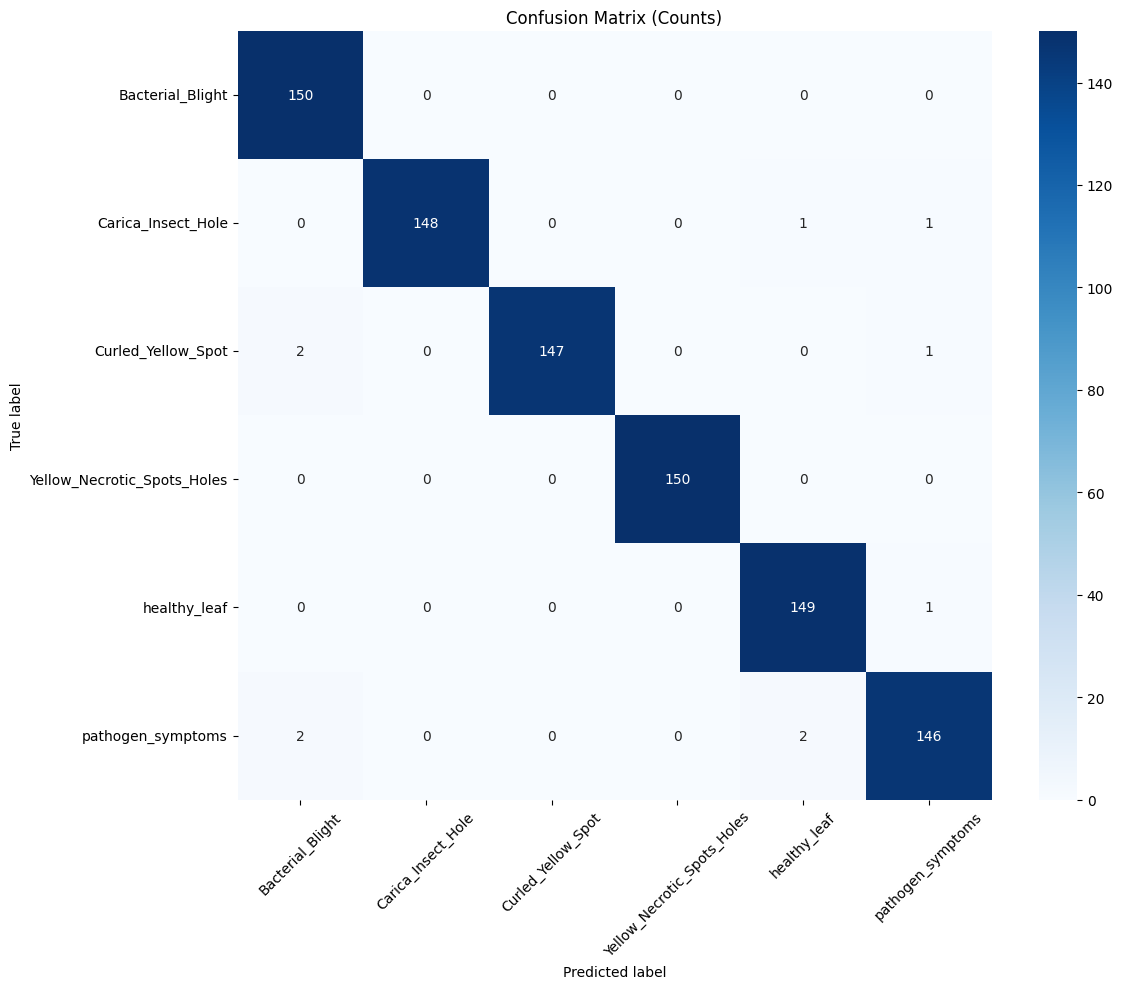

Normalized confusion matrix


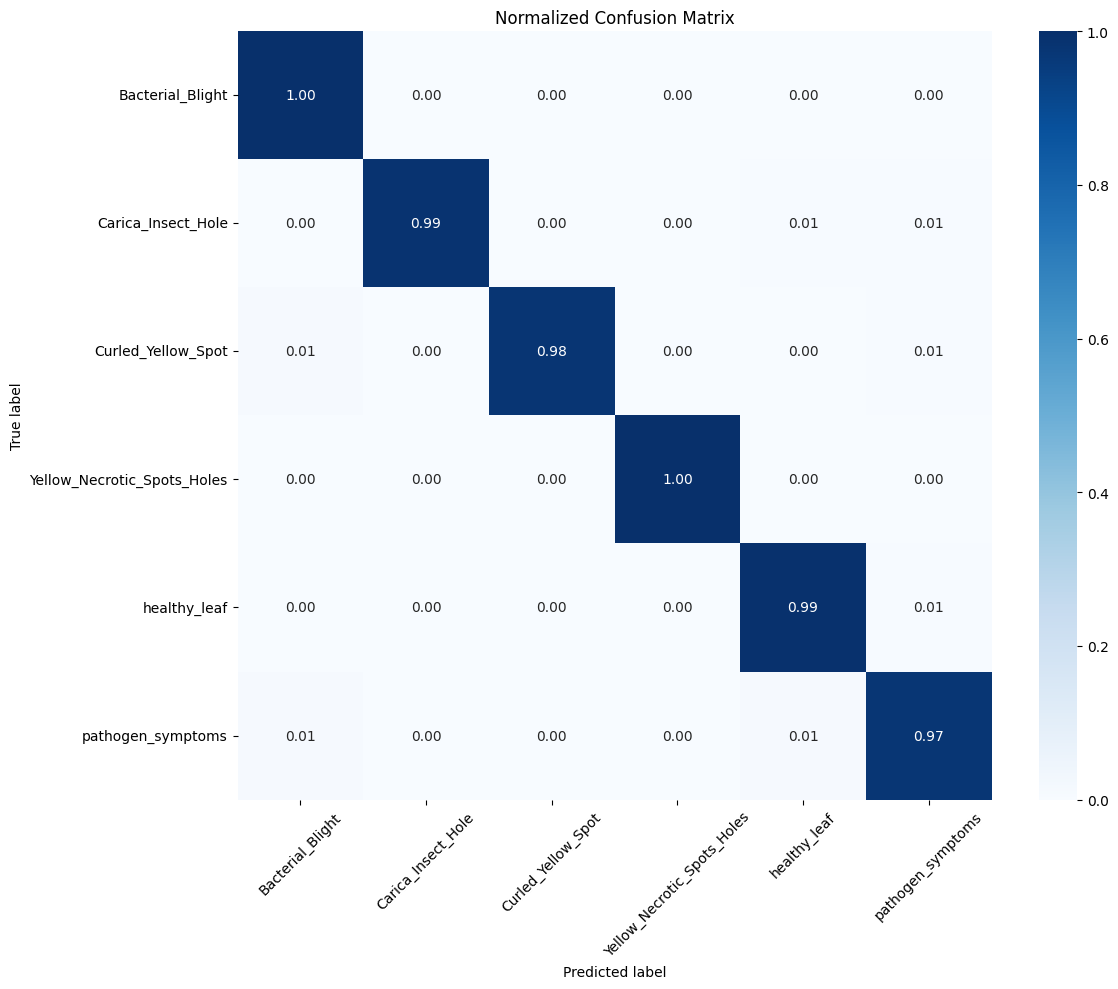

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Get predictions and true labels from test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)

# 2. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 3. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names,
                      title='Confusion Matrix (Counts)')

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix')

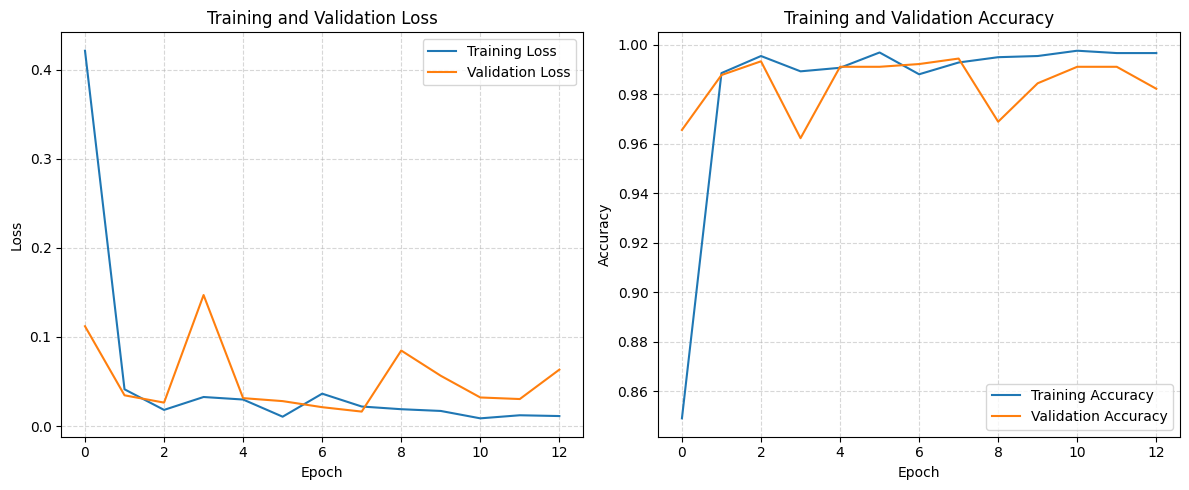


Best Validation Loss: 0.0162 at epoch 8
Corresponding Training Loss: 0.0219
Validation Accuracy at Best Epoch: 0.9945


In [14]:
import matplotlib.pyplot as plt

# Get training history from model.fit()
history = model.history.history

# Create figure with two subplots
plt.figure(figsize=(12, 5))

# 1. Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Optional: Print best validation accuracy
best_val_epoch = np.argmin(history['val_loss'])
print(f"\nBest Validation Loss: {min(history['val_loss']):.4f} at epoch {best_val_epoch + 1}")
print(f"Corresponding Training Loss: {history['loss'][best_val_epoch]:.4f}")
print(f"Validation Accuracy at Best Epoch: {history['val_accuracy'][best_val_epoch]:.4f}")

 5/29 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


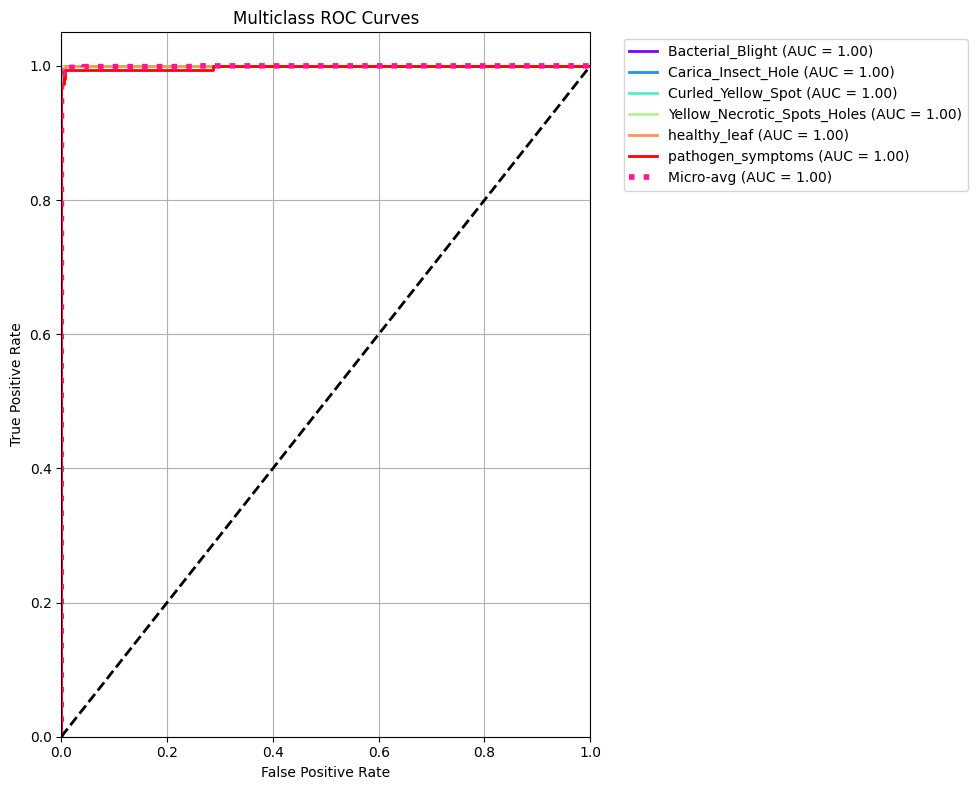


AUC Scores:
Bacterial_Blight: 1.0000
Carica_Insect_Hole: 1.0000
Curled_Yellow_Spot: 0.9999
Yellow_Necrotic_Spots_Holes: 1.0000
healthy_leaf: 1.0000
pathogen_symptoms: 0.9980

Micro-average AUC: 0.9995


In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# 1. Get predictions and true labels from test set
y_pred = model.predict(test_ds)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_true_labels = np.argmax(y_true, axis=1)  # Convert one-hot to labels

# 2. Binarize the true labels for multiclass ROC
y_true_bin = label_binarize(y_true_labels, classes=np.arange(NUM_CLASSES))

# 3. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Compute micro-average ROC curve and area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 5. Generate enough colors for all classes
colors = cycle(plt.cm.rainbow(np.linspace(0, 1, NUM_CLASSES)))

# 6. Plot ROC curves
plt.figure(figsize=(10, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

# Plot micro-average curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-avg (AUC = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Print AUC scores
print("\nAUC Scores:")
for i in range(NUM_CLASSES):
    print(f"{class_names[i]}: {roc_auc[i]:.4f}")
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")

 5/29 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


2025-06-18 17:26:41.436400: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


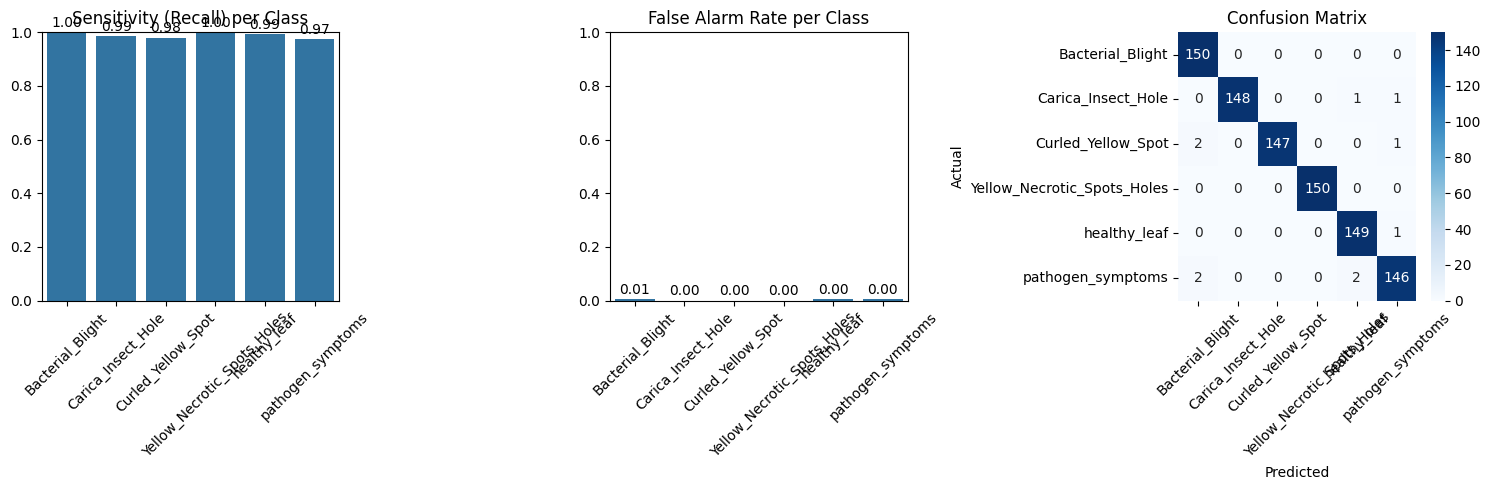


Class-wise Performance Metrics:
Class          Sensitivity    False Alarm Rate    
--------------------------------------------------
Bacterial_Blight1.0000         0.0053              
Carica_Insect_Hole0.9867         0.0000              
Curled_Yellow_Spot0.9800         0.0000              
Yellow_Necrotic_Spots_Holes1.0000         0.0000              
healthy_leaf   0.9933         0.0040              
pathogen_symptoms0.9733         0.0040              

Macro-average Sensitivity: 0.9889
Macro-average False Alarm Rate: 0.0022


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score

# 1. Get predictions and true labels
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)

# 2. Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# 3. Calculate metrics for each class
sensitivity = []
false_alarm_rate = []
precision = []

for i in range(len(class_names)):
    # Sensitivity (Recall)
    sensitivity.append(recall_score(y_true, y_pred_classes, labels=[i], average=None)[0])
    
    # False Alarm Rate = FP / (FP + TN)
    fp = np.sum(cm[:, i]) - cm[i, i]
    tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
    false_alarm_rate.append(fp / (fp + tn))


# 4. Create visualization
plt.figure(figsize=(15, 5))

# Sensitivity plot
plt.subplot(1, 3, 1)
sns.barplot(x=class_names, y=sensitivity)
plt.title('Sensitivity (Recall) per Class')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(sensitivity):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')

# False Alarm Rate plot
plt.subplot(1, 3, 2)
sns.barplot(x=class_names, y=false_alarm_rate)
plt.title('False Alarm Rate per Class')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(false_alarm_rate):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')

# Confusion Matrix
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# 5. Print metrics table
print("\nClass-wise Performance Metrics:")
print(f"{'Class':<15}{'Sensitivity':<15}{'False Alarm Rate':<20}")
print("-"*50)
for i in range(len(class_names)):
    print(f"{class_names[i]:<15}{sensitivity[i]:<15.4f}{false_alarm_rate[i]:<20.4f}")


# 6. Calculate macro averages
macro_sensitivity = np.mean(sensitivity)
macro_far = np.mean(false_alarm_rate)
print(f"\nMacro-average Sensitivity: {macro_sensitivity:.4f}")
print(f"Macro-average False Alarm Rate: {macro_far:.4f}")